# Comparing the performances of the two simulation dynamics

The synchronous dynamics is simple but (we claim) potentially inefficient, because it processes "empty bins" where no events happen. By contrast, stochastic dynamics has no such overheads, and trades a more complicated mathematical formulation for improved performance.

In this notebook we test the efficiency claims by comparing the two dynamics on simulations on the same kind of network. We'll also check whether they are coimparable in other ways, for example do they generate events in the same pattern over time.

In [3]:
# simulation support
from epyc import Experiment
from epydemic import SIR, ERNetwork, SynchronousDynamics, StochasticDynamics

# analysis and plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['font.size'] = 10
import matplotlib.pyplot as plt

We will choose a set of disease and network parameters to tryt with both approaches.

In [38]:
params = dict()

# ER network parameters
params[ERNetwork.N] = int(1e5)
params[ERNetwork.KMEAN] = 20

# SIR parameters
params[SIR.P_INFECTED] = 0.001
params[SIR.P_INFECT] = 0.002
params[SIR.P_REMOVE] = 0.001

We also need a process model.

In [6]:
m = SIR()

## Synchronous dynamics

Let's begin with the synchronous case.

In [39]:
sim = SynchronousDynamics(m, ERNetwork())
syn = sim.set(params).run()

print('Epidemic covered {percent:.2f}% of the network'.format(percent=(syn[Experiment.RESULTS][SIR.REMOVED] / params[ERNetwork.N]) * 100))

So we got a large epidemic.

## Stochastic dynamics

Running the same experiment using the stochastic dynamics, we'd expect to get similar results.

In [42]:
sim = StochasticDynamics(m, ERNetwork())
sto = sim.set(params).run()

print('Epidemic covered {percent:.2f}% of the network'.format(percent=(sto[Experiment.RESULTS][SIR.REMOVED] / params[ERNetwork.N]) * 100))

{'epydemic.sir.S': 0, 'epydemic.sir.I': 0, 'epydemic.sir.R': 100000}
Epidemic covered 100.00% of the network


That certainly seems to be comparable at a gross level, which gives (some) confidence that they two techniques generater the same size of epidemic overall.

## Comparison

We can of course dig-into the results in more detail. There are a lot of potentially interesting things to explore, and we'll just pick two of the most important: is one method faster than the other?, and, do they look like they generate a similar train of events?

### Performance

Probably the most important measure of performace is "wallclock time", the time that elapsed while the simulation ran: 

In [44]:
print("Synchronous {elapsed:.2f}s".format(elapsed=syn[Experiment.METADATA][Experiment.ELAPSED_TIME]))
print("Stochastic  {elapsed:.2f}s".format(elapsed=sto[Experiment.METADATA][Experiment.ELAPSED_TIME]))

Synchronous 380.87s
Stochastic  55.89s


Where is the time difference coming from? The synchronous simulation simulated a lot of timesteps where nothing happened: there were no events, just from the random nature of the process and the rates of events. The stochastic simulation jumped over these empty periods and only did work when there was work to do. That's clearly a benefit, and one can imagine that, for larger simulations and those whose events are less frequent, it might become a really significant computational saving.

If you change the experimental parameters you can construct alternative scenarios, though. For example, having high-probability events pushes the events together, meaning there are fewer empty bins and so less overhead. (I've even found cases where the synchronous dynamics is *faster* than the stochastic, although only slightly.) The point is, though, that the stochastic dynamics is more *reliably* fast than the synchronous, and so is probably to be preferred unless you really need the extra flexibility.

### Equivalence of event intervals

But a performance benefit is only useful if the results are correct: there's no point in doing the wrong things faster, after all. So we need to convince ourselves that, at the very least, the two simulations conducted for the same parameters produce plausibly comparable results &ndash; even while we accept that statistical variations might occur.

Although we are using two different simulation techniques, we claim that they are "the same" in the sense of simulating the same process dynamics. One way to test this is to look at the distance between successive events. If the events are happening with similar distributions, we would expect the inter-event time distributins to be similar too.

To do this we need to capture when (in simulation time) each event occurs. We can do this quite simply, by defining a new compartmented model whose results include the simulation times for events.

In [61]:
class SIR_EventDistribution(SIR):
    '''An SIR model that also captures the times of all events.'''
    
    def __init__(self):
        super().__init__()
        
        # create a place to store the sequence of event times
        self._eventDistribution = []
        
    def reset(self):
        super().reset()
        self._eventDistribution = []

    def results(self):
        rc = super().results()
        
        # add the event times to the results
        rc['event_times'] = self._eventDistribution
        
        return rc

    def infect(self, t, e):
        # perform the base event
        super().infect(t, e)
        
        # record the event time
        self._eventDistribution.append(t)
        
    def remove(self, t, n):
        # perform the base event
        super().remove(t, n)
        
        # record the event time
        self._eventDistribution.append(t) 

We can now run the same process with different dynamics, and capture the event trains that are generated.

In [62]:
# new model
m = SIR_EventDistribution()

# synchronous dynamics
sim = SynchronousDynamics(m, ERNetwork())
syn_res = sim.set(params).run()
syn_events = syn_res[Experiment.RESULTS]['event_times']

# stochastic dynamics
sim = StochasticDynamics(m, ERNetwork())
sto_res = sim.set(params).run()
sto_events = sto_res[Experiment.RESULTS]['event_times']

We can now compute the inter-event times. Since we're working with continuous and discrete time depending on the dynamics, histogramming the intervals should generate similar curves: 

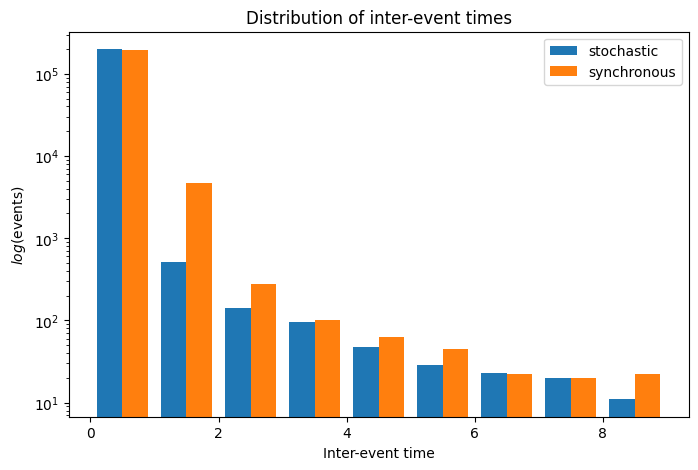

In [64]:
fig = plt.figure(figsize = (8, 5))

# work out inter-event times
l = 0
syn_inter = []
for i in range(1, len(syn_events) - 1):
    syn_inter.append(syn_events[i] - l)
    l = syn_events[i]
sto_inter = []
l = 0
for i in range(1, len(sto_events) - 1):
    sto_inter.append(sto_events[i] - l)
    l = sto_events[i]

# plot the histogram of the distribution
plt.hist([sto_inter, syn_inter],
         bins = range(10),
         log = True,
         label = ['stochastic', 'synchronous'])

plt.title('Distribution of inter-event times')
plt.xlabel('Inter-event time')
plt.ylabel('$log(\mathrm{events})$')
plt.legend()
_ = plt.show()

So those are *similar*, both dropping off exponentially as we'd expect. They don't follow exactly the same distribution, but that could just be the result of the stochastic nature of the process: we ran the two dynamics over the same network, but from different initial (random) seedings of nodes. Or it could be because the synchronous approach is less exact because of interactions between events. If we wanted a closer look, we'd have to perform some repetitions to see whether we got different results repeatedly or whether things evened out &ndash; but that's something for another time.